In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import pickle
import sys
import os

warnings.filterwarnings("ignore")


PROJECT_DIRECTORY = os.path.join(os.getcwd(), '..')
sys.path.append(PROJECT_DIRECTORY)


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


from src.features_processing import *
from src.model_evaluation import *

# Carregando bases de treino e teste

In [ ]:
AUX_VAR_PATH     = PROJECT_DIRECTORY + '/models/artefacts/aux_vars.pickle'
TARGET_VARS_PATH = PROJECT_DIRECTORY + '/models/artefacts/target_vars.pickle'
NUM_VARS_PATH    = PROJECT_DIRECTORY + '/models/artefacts/num_vars.pickle'
CAT_VARS_PATH    = PROJECT_DIRECTORY + '/models/artefacts/cat_vars.pickle'

CAT_IMPUTER_PATH = PROJECT_DIRECTORY + '/models/artefacts/cat_imputer.pickle'
NUM_IMPUTER_PATH = PROJECT_DIRECTORY + '/models/artefacts/num_imputer.pickle'

CAT_ENCONDER_PATH = PROJECT_DIRECTORY + '/models/artefacts/cat_encoder.pickle'
NUM_SCALER_PATH   = PROJECT_DIRECTORY + '/models/artefacts/num_scaler.pickle'

SELECTED_VARS_PATH = PROJECT_DIRECTORY + '/models/artefacts/selected_vars.pickle'


with open(AUX_VAR_PATH,'rb') as f:
    aux_vars = pickle.load(f)

with open(TARGET_VARS_PATH,'rb') as f:
    target_vars = pickle.load(f)

with open(SELECTED_VARS_PATH,'rb') as f:
    selected_vars = pickle.load(f)

In [ ]:
abt_treino = pd.read_parquet(PROJECT_DIRECTORY + '/data/processed/abt_treino.parquet')
abt_teste = pd.read_parquet(PROJECT_DIRECTORY + '/data/processed/abt_teste.parquet')


abt_treino = tratamento_completo(df = abt_treino,
                                 aux_vars_path    = AUX_VAR_PATH,
                                 target_var_path  = TARGET_VARS_PATH,
                                 num_vars_path    = NUM_VARS_PATH,
                                 cat_vars_path    = CAT_VARS_PATH,
                                 cat_imputer_path = CAT_IMPUTER_PATH,
                                 num_imputer_path = NUM_IMPUTER_PATH,
                                 cat_encoder_path = CAT_ENCONDER_PATH,
                                 num_scaler_path  = NUM_SCALER_PATH)


abt_teste = tratamento_completo(df = abt_teste,
                                 aux_vars_path    = AUX_VAR_PATH,
                                 target_var_path  = TARGET_VARS_PATH,
                                 num_vars_path    = NUM_VARS_PATH,
                                 cat_vars_path    = CAT_VARS_PATH,
                                 cat_imputer_path = CAT_IMPUTER_PATH,
                                 num_imputer_path = NUM_IMPUTER_PATH,
                                 cat_encoder_path = CAT_ENCONDER_PATH,
                                 num_scaler_path  = NUM_SCALER_PATH)

# Carregando Modelo Final

In [ ]:
FINAL_MODEL_PATH = PROJECT_DIRECTORY + '/models/trained_model/final_model.pickle'

with open(FINAL_MODEL_PATH,'rb') as f:
    model = pickle.load(f)

# Obtendo Scores

In [ ]:
abt_treino['score'] = model.predict_proba(abt_treino[selected_vars])[:, 1]
abt_teste['score'] = model.predict_proba(abt_teste[selected_vars])[:, 1] 

# Ordenação por Quantil

In [ ]:
# Cria os labels desejados
decile_labels = [f"Quantil_{i}" for i in range(1, 11)]

# Aplica o qcut com os labels
abt_treino['quantil_score'] = pd.qcut(abt_treino['score'], q=10, labels=decile_labels)
abt_teste['quantil_score'] = pd.qcut(abt_teste['score'], q=10, labels=decile_labels)

,Métrica,Treino,Validação
0,KS,52.922649,31.639188
1,AUC,0.845314,0.717642
2,Gini,69.062743,43.528415


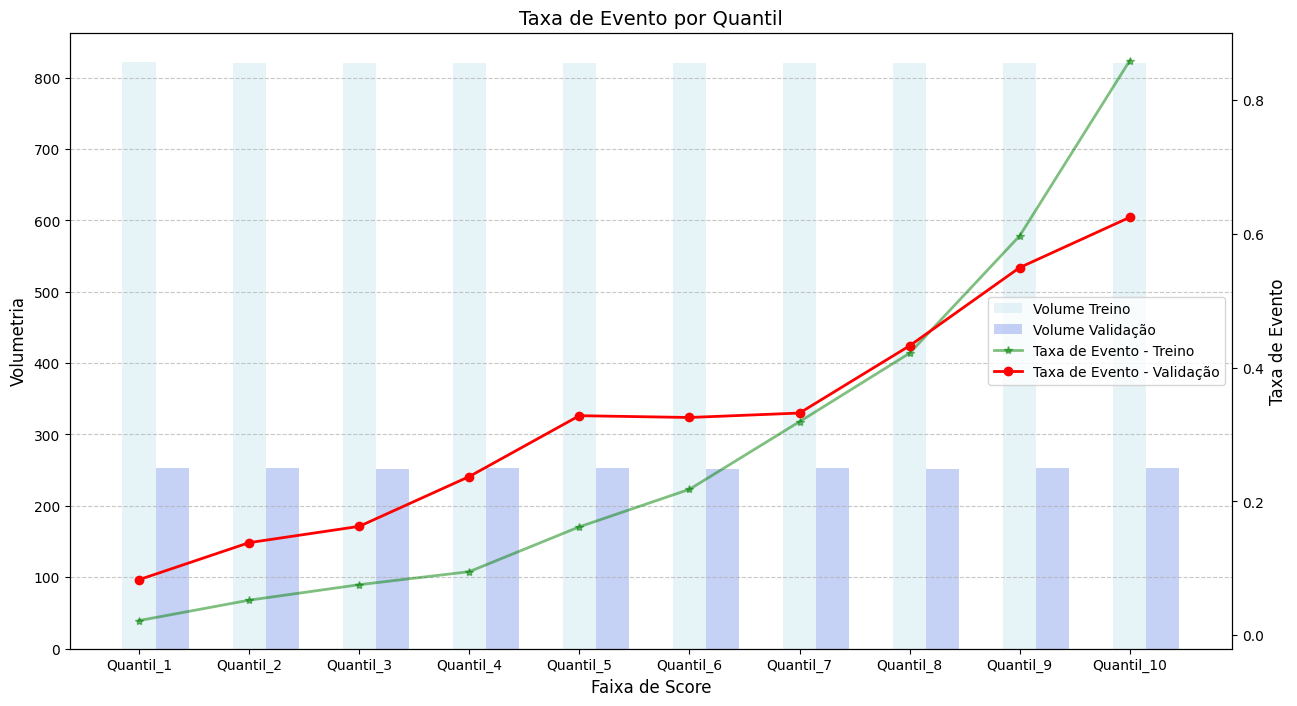

In [ ]:
tabela_comparativa = compare_performance(abt_treino['y'], abt_treino['score'],
                    abt_teste['y'],abt_teste['score'])

display(tabela_comparativa)


table_treino = construct_metrics_table(abt_treino,'quantil_score','score','y')
table_val = construct_metrics_table(abt_teste,'quantil_score','score','y')

fig, ax1 = plt.subplots(figsize=(15, 8))

barWidth = 0.3
r1 = np.arange(len(table_treino['quantil_score']))
r2 = [x + barWidth for x in r1]


# Configuração da figura e do gráfico de barras
ax1.bar(r1, table_treino['volume'], color='lightblue', width = barWidth,alpha = 0.3, label='Volume Treino')
ax1.bar(r2, table_val['volume'],    color='royalblue', width = barWidth,alpha = 0.3, label='Volume Validação')

ax1.set_ylabel('Volumetria', fontsize=12)
ax1.set_xlabel('Faixa de Score', fontsize=12)


ax2 = ax1.twinx()
ax2.plot(table_treino['quantil_score'], table_treino['event_rate'], color='green', marker='*', linewidth=2, alpha = 0.5, label='Taxa de Evento - Treino')
ax2.plot(table_val['quantil_score'], table_val['event_rate'], color='red', marker='o', linewidth=2, label='Taxa de Evento - Validação')
ax2.set_ylabel('Taxa de Evento', fontsize=12)


ax1.set_xticks(np.arange(len(table_treino['quantil_score'])))
ax1.set_xticklabels(decile_labels, ha = 'center')

# Adicionar título e grades
plt.title('Taxa de Evento por Quantil', fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# # Adicionar legenda
fig.legend(loc="center right", bbox_to_anchor=(1, 0.5), bbox_transform=ax1.transAxes)

plt.savefig(PROJECT_DIRECTORY + '/reports/taxa_evento_quantil.jpeg')
plt.show()

# Curva de calibração

Brier Score: 0.2043
Expected Calibration Error (ECE): 0.1103


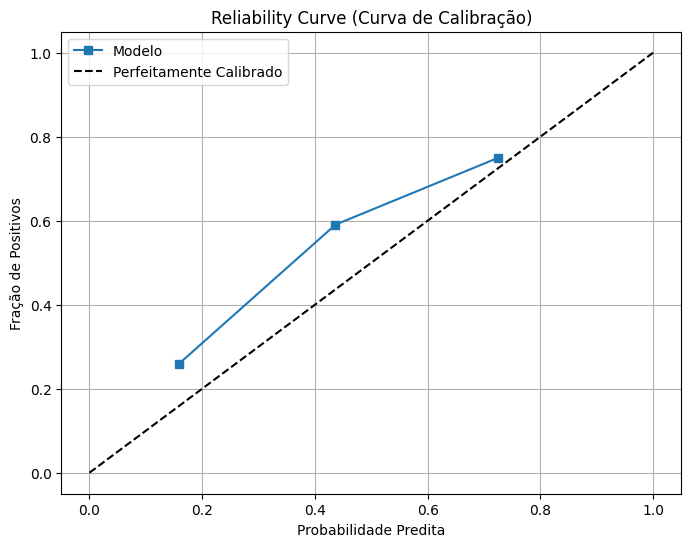

In [ ]:
calibration_metrics(abt_teste['y'], abt_teste['score'], n_bins=3)

# Ks por Safra

In [ ]:
abt = pd.concat([abt_treino,abt_teste])

In [ ]:
# Aplica a função por safra usando apply
df_ks = abt.groupby('safra').apply(lambda df: calculate_ks(df['y'], df['score'])).reset_index()
df_ks.columns = ['safra', 'ks']

In [ ]:
df_ks['label'] = np.where(df_ks['safra'].isin(['201410','201411','201412']),'Teste','Treino')

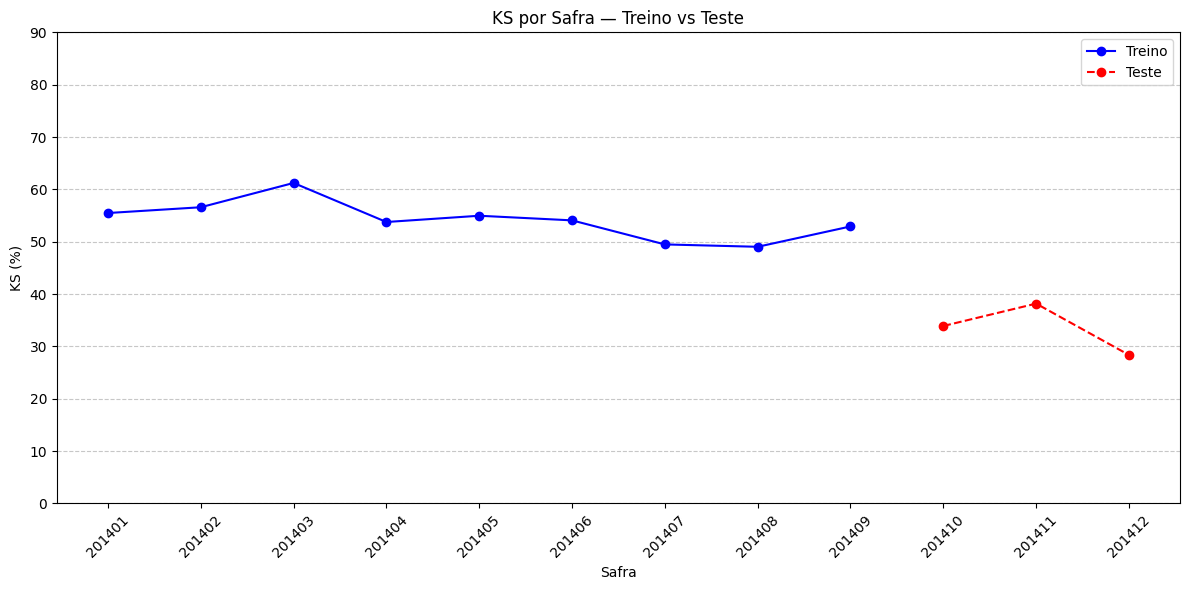

In [ ]:
# Garante que a safra seja tratada como número para ordenar corretamente
df_ks = df_ks.sort_values(by='safra')

# Cria a figura
plt.figure(figsize=(12, 6))

# Para que as linhas sejam contínuas e ordenadas, use o agrupamento após ordenação
for label in df_ks['label'].unique():
    df_sub = df_ks[df_ks['label'] == label]
    plt.plot(df_sub['safra'], df_sub['ks'],
             label=label,
             marker='o',
             linestyle='-' if label == 'Treino' else '--',
             color='blue' if label == 'Treino' else 'red')


# Ajustes do gráfico
plt.title('KS por Safra — Treino vs Teste')
plt.xlabel('Safra')
plt.ylabel('KS (%)')
plt.yticks(range(0,100,10))
plt.xticks(df_ks['safra'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
psi_table = {f: calculate_psi(abt_treino[f], abt_teste[f]) for f in selected_vars}
psi_df = (pd.Series(psi_table, name="PSI")
            .reset_index().rename(columns={"index":"Variável"})
            .assign(flag=lambda d: np.where(d.PSI>0.25,"Mudança severa",
                                            np.where(d.PSI>0.10,"Mudança moderada","Sem Mudanças"))))

NameError: name 'calculate_psi' is not defined

In [ ]:
psi_df.sort_values('PSI',ascending=False).head(10)

,Variável,PSI,flag
5,VAR_53,0.983515,Mudança severa
10,VAR_54,0.623935,Mudança severa
7,VAR_30,0.209654,Mudança moderada
0,VAR_1,0.107737,Mudança moderada
9,onehotencoder__VAR_2_0.0,0.085932,Sem Mudanças
12,onehotencoder__VAR_3_0.0,0.079131,Sem Mudanças
24,onehotencoder__VAR_3_1.0,0.078762,Sem Mudanças
8,VAR_27,0.069989,Sem Mudanças
13,onehotencoder__VAR_4_0.0,0.063349,Sem Mudanças
15,VAR_17,0.046608,Sem Mudanças
